# Class Statudio : Take 2.718🎬🎬

Description:
====
An instance of class OnSource begins by constructing multiple random waveform datasets, alongside known waveforms spanning a provided parameter space. Afterwards, it computes the cross-correlation and chi-square statistics between all dataset and wave template pairs, organizes the output into a dictory, and saves said dictionary into 'outputfile.json' within the current directory.

Current Issue:
====
- The dictrionary seems to be to large to directly save through the notebook; so i've commented it out. The saving feature seems to work fine from my computer though.
- The codes big, and needs to be commented better; I should probably make a write up for the methods too
- I should proabably parallelize the code with ray
- I need to be read the code for 'unknown unknown' errors
- I should see if I can speed anything up with numpy anywhere
- Off topic, but I still don't know why the below 'methods' section doesn't display tables properly
- the 'exec()' functions could almost surely be used to streamline inputing test statistics/ test waveforms into the function

Methods:
====
1. Constructor: 
 - inputs:
    Most of the constructors inputs are to help define the parameter space and waveform intervals...
   
    eng. name | lower bound | upper bound| divison 
    ------------ | ------------- | ------------- | -------------
    Amplitude | A0 | Af | N_A
    Frequency | F0 | Ff | N_f
    Gamma | g0 | gf | N_g
    Noise interval|  | T | N_t
 
 <br>
    Outside of the above, we also have...
    
    \# of data trials | noise amplitude | foreground/background half-widths | template width |
    ------------ | ------------- | ------------- | -------------
    trials | b | d | t0_tf
    
 - outputs:
     see class description





2. waveform: 
generates a dataset of noise + injected waveform; the injected waveform has freqeuncy, amplitude, gamma and start time t0 selected randomly from the parameter space. Really just used to construct the required datasets used in the constructor class
 - inputs:
 
    noise amplitude | interval length | phase | divisions
    ------------- | ------------- | ------------- | -------------
    b | d_end_t | phi | N (=N_t)

 - outputs:
 
     random parameters | time-step  | time array | dataset waveform
    ------------- | ------------- | ------------- | -------------
    \[f, A, $\gamma$, t_RAN \] | dt | T_full | d




3. template:
Produces a template given a position in parameter space
 - inputs:
 
    amplitude | frequency | gamma | interval length | time-step
    ------------- | ------------- | ------------- | ------------- | -------------
    A | f | gamma | duration | dt

 - outputs:
 
     template np array |
    ------------- | 
     A * np.sin(w*t)*np.exp(-gamma*t) |
    
    
    
4. CrossCorrelation
Produces a cross corelation function given a data input and a template in parameter space
 - inputs:
 
    data | template | time-step
    ------------- | ------------- | -------------
    data | template | dt

 - outputs:
 
     cross correlation |
    ------------- | 
     M |

                                            
    
  
5. ChiSquare: 
Produces chi square at each "slide"
 - inputs:
 
    data | template | time-step
    ------------- | ------------- | -------------
    data | template | dt

 - outputs:
 
     chi cquare |
    ------------- | 
     C |


6. Rho:
builds provided test-statistic internally

7. modulator:
performs windowing on a given input

8. window:
performs windowing on the internally stored test statistic values
also builds foreground/ background values, and stores them internally as well

9. test_plotter:
plots threshold vs. success-count
* T: threshold range
* N: Number of divisions of threshold region
* var1, var2 : index of variables to be plotted (0=A, 1=f, 2=g)
* bg_test : boolean kwarg; includes/discludes 'on source greater than max noise' condition

10. Scatter_plotter:
plots pass /fails of the threshold condition 
* thrshld: threshold value to clear
* xvar, yvar : index of variables to be plotted

11. heatmap
plots a heat map of 
    - avg. rhos per choice of two index
    - max background value per template per choice of two index 
    
* T : threshold value (all lower values mapped to black)
* max_OS : sets value of 'white' in avg rho plots; max OS by default
* max_BG : sets value of 'white' in max background plots; max BG by default 



# Actual Code

In [1697]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import time

class Statudio:
    
    def __init__(self, N_A, N_g, N_f, t0_tf, T, b, D, trials, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000):
       
        print('very start...')
        """
        METHOD: 
        Generates a set of wave templates spanning the parameter space of amplitude, frequency and gamma;
        Generates a set of datasets with injected signals via random A, f, gamma, and start time
        Creates cross-correlation/chi-squared stats with the above
        Lastly, saves the above internally as attributes, and externally as a .json file
        
        PARAMETERS:
        -----------
        N_A: divisions in amplitude
        N_g:  divisions in gamma
        N_f: divisions in frequency
        t0_tf: length of template interval [t0, tf] in time
        T: length of total time series, in units of time
        b: noise amplitude
        D: foreground/background interval length
        trials: number of random data sets generated
        A0, Af : amplitude lower/upper bounds
        g0, gf : gamma lower/upper bounds
        F0, ff : frequency lower/upper bounds
        N_t= divisions in total time series 
        
        OUTPUT: Returns global maximum values for given ranges, and produces txt
        value containing all of them
        """
        
        
        print('initalizing output...')
        """initalizes a dictionary of arrays to hold info and later save as a .json
        key i: returns an array of arrays containing datset i and other relavent values
                component 0: true A, f, g & t0 corresoponding to dataset i
                component 1: dataset i
                component 2: cross corelations between dataset and each template
                component 3: chi squares between dataset and each template
        """
        self.trials=trials
        output={}
        for i in range(self.trials):
            output.update({i:[[],[],[],[]]})
        
        
        
        print('initalizing attributes...')
        # initalizes the arrays which span parameter space, and their lengths
        self.A_RANGE=np.linspace(A0,Af,N_A)
        self.G_RANGE=np.linspace(g0,gf,N_g)
        self.F_RANGE=np.linspace(F0,Ff,N_f)
        
        self.A_LEN, self.G_LEN, self.F_LEN = len(self.A_RANGE), len(self.G_RANGE), len(self.F_RANGE)
        
        self.N=N_t
        
        # Constructs timestep resolution, and saves t0/tf internally 
        self.dt, self.t0_tf= T/N_t, t0_tf
        
        # constructs time range to pick injected signal start time from/ corresponding length 
        self.t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/(T)))))
        self.t_LEN=len(self.t_RANGE)
        self.T=T

        # initialize arrays for various data/cross-correlations/chi-squares 
        self.noise = []
        self.cross_cor=[]
        self.chi=[]
        
        
        
        print('building pairs/templates...')
        # constructs all templates which correspond to points in the parameter space
        self.TEMPLATES_AFG=[ self.template( A, f, g, t0_tf, self.dt) for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        self.AFG_PAIR=[ [A, f, g] for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
       
    
    
        print('starting data/template loop...')
        for i in range(trials):            
            
            # generates data
            temp_AFGT, data = self.waveform(N_t, T, t0_tf, b)
            
            self.noise.append(data) 
            output[i][0], output[i][1] = list(temp_AFGT), list(data)  ## stores random a-g-f pair / data set 
            
            
            CRS_COR, CHI_SQR = [[],[]]
            
            # performs base static calculation accross parameter space
            for template in self.TEMPLATES_AFG:
            
                CC_dh=list(self.CrossCorrelation(data, template, self.dt))
                CRS_COR.append(CC_dh)
                                            
                CS_dh=list(self.ChiSquare(data, template, self.dt))
                CHI_SQR.append(CS_dh)
            
            #stores base statistics in appropriate attribute/ output
            self.cross_cor.append(CRS_COR)
            self.chi.append(CHI_SQR)
            output[i][2], output[i][3] = CRS_COR, CHI_SQR
        
        #sets output as a attribute
        self.output=output
        
        #saves 'output' as a .json in current working directory.
        '''with open('outputfile', "w") as f:
            json.dump(output, f, indent=2, sort_keys=True)'''
    
    
    
    
            
    def waveform(self, N, T, t0_tf, B, phi0=0):
    
        #calculates random parameters A, f, g
        A_RAN=np.random.randint(0,self.A_LEN)
        G_RAN=np.random.randint(0,self.G_LEN)
        F_RAN=np.random.randint(0,self.F_LEN)
        
        f, A, gamma = self.F_RANGE[F_RAN], self.A_RANGE[A_RAN],  self.G_RANGE[G_RAN] 
    
        dt=T/N
    

        NOISE = np.random.normal(scale=(B/(math.sqrt(3)*2)), size=N)  # Noise!

    
        t0=(T-t0_tf)*np.random.random(1)[0]  # Randomly generate start time
        START_INDEX=math.floor(t0/dt)        # find index associated with time

    
        ##NOTE: using 't0' instead of some multiple of dt may cause issues later
    
        SIG_LEN =( math.floor(t0_tf/dt)+1 if (t0_tf != T) else N )      # Calculate # of indexes signal takes
        INJECTED = np.zeros(N)                       #initalize injected signal
        for i in range(SIG_LEN):
            INJECTED[ START_INDEX + i]=t0+i*dt       #fill in injected signal

        w = 2 * np.pi * f
    
        SR = INJECTED[ START_INDEX : START_INDEX+SIG_LEN][:]
        INJECTED[ START_INDEX : START_INDEX+SIG_LEN] = A*np.sin(w*(SR-t0) + phi0)*np.exp(-gamma*( SR-t0))
        D_i = NOISE + INJECTED  # Complete Data!
    
        return [A, f, gamma, t0], D_i


    
    
    
    #calculates test statistic, stroes it internally,
    #and returns a copy of it as a dictionary 
    def rho(self):
        #counts number of tempates in parameter space
        PSPACE_LEN=len(self.AFG_PAIR)
    
        #initalizes rho statistic dictionary
        self.RHO={}
    
        #indexed to loops through dataset trials
        for i in range(self.trials):
            rho_i=[]
        
            #indexed to loops through parameter space templates and
            #calculates each rho_ij given template j
            for j in range(PSPACE_LEN):
                CC_IJ=np.array(self.cross_cor[i][j][:])
                CS_IJ=np.array(self.chi[i][j][:])
                
                            ##1. function_input="f(CC,CS)"
                            ##2. exec("p="+function_input)
                            ##3. rho_i.append( list( p )) )
                            ##4. ...
                            ##5. profit?
                            
                rho_i.append( list( (CC_IJ/(1+CS_IJ) )) ) 
            
            self.RHO.update({ i : rho_i })
        return self.RHO

    
    
    
    
    def modulator(self, rho_ij, D):
       
        rho_mod_D, RHO_ij = [] , rho_ij[:]
    
        dn , L = math.floor(2*D/self.dt) , len(RHO_ij)

        for i in range(0,L-(L%dn),dn):
            rho_mod_D.append(max(RHO_ij[i:i+dn]))
        
        if (L-(L%dn)) != L :
            rho_mod_D.append(max(RHO_ij[L-(L%dn):L]))
        
        return rho_mod_D
    
    
    
    
    
    def window(self, D):
        
        if (2*D >= self.dt):
            
            print('initalizing output...')
            """Build a dictionary of arrays that hold rho off-source/on-source values
            key i: returns ndim-arrays containing rho statistics of dataset_i
                component [0][j]: returns off-source array for template j
                component [1][j]: returns on-source scalar for template j
            """
            
            #gets the length of linearized template space
            TEMP_LEN=len(self.cross_cor[0])
            
            self.RHO_MOD={}
            self.MAX_OS={}
            self.MAX_BG_TEMP={}
            
            for j in range(TEMP_LEN):
                self.MAX_BG_TEMP.update({ j : 0})
                
            for i in range(self.trials):
    
                #calculates bg values + fg values
                BG_VALS_IJ=[self.modulator( self.RHO[i][j][:] ,D ) for j in range(TEMP_LEN)]
            
                #seperates fg value from bg value
                T0_2D=math.floor(self.output[i][0][3]/(2*D))
            
                print("t0: "+str(self.output[i][0][3])+"  T0_2D: "+str(T0_2D))
            
                FG_VAL_IJ=[ BG_VALS_IJ[j].pop(T0_2D) for j in range(TEMP_LEN)]
                
                self.RHO_MOD.update({ i: [ BG_VALS_IJ, FG_VAL_IJ ] })
        
                self.MAX_OS.update({ i :[tuple(self.output[i][0][0:3]),max(self.RHO_MOD[i][1])] })
                
                for j in range(TEMP_LEN): 
                    new_max=max(self.RHO_MOD[i][0][j])
                    
                    if (self.MAX_BG_TEMP[j]< new_max):
                        self.MAX_BG_TEMP[j]=new_max
                
                
            return self.RHO_MOD
        
        else: 
            print("invalid D; it is required that 2*D >= T/N")
    
    

    def test_plotter(self, T, N, var1=0, var2=0,bg_test=True):
        
        # Calculates the index of the attribute variable
        # (A, F, or G) which the heat map should marginaliz 
        # over
        if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
            if ((0<= var1) and (0<= var2)):  #checks if range valid
                if (var2 < var1):            #properly orders
                    var1, var2 = var2, var1
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index
                    
                elif (var2==var1):
                    index=var2  # if the values are the same, set as index
                    
                else:
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            else:
                print("improper index inputs: both must be >= 0")
                index=0
        else:
            print("improper index inputs: both must be <= 2")
            index=0
            
             
                
                
        mapping={}   #initalizes mapping for heat map
    
        holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        
        # builds link between keys and np-array 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    F=self.F_RANGE[j]
                    A=self.A_RANGE[i]
                    G=self.G_RANGE[k]
            
                    holder[(i,j,k)]=[0]
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})
                    
                
        
        #initalizes threshold axis points, counts for each threshold
        #and space of parameter space
        THRS_AXIS=[]
        COUNT_AXIS=[]
        PSPACE_LEN=len(self.AFG_PAIR)
        PSACE_PAIRS=[]

        #sets current threshold value
        for thrshld in np.linspace(0,T,N):

            THRS_AXIS.append(thrshld)
            succ_count_thrhld=0
        
            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                heat_count=0
                for j in range(PSPACE_LEN):
                
                    RM_ij=np.array(self.RHO_MOD[i][0][j])
                    FG_ij=self.RHO_MOD[i][1][j]
                    N_BG_ij=len(RM_ij[ RM_ij > FG_ij])
                
                    #tests if the given pair passes the threshold test
                    if (bg_test==True):
                        if ((N_BG_ij==0) and (FG_ij > thrshld)):

                            if heat_count==0:
                                succ_count_thrhld+=1
                                mapping[tuple(self.output[i][0][:3])][0]+=1
                                heat_count+=1
                    else:
                        if (FG_ij > thrshld):

                            if heat_count==0:
                                succ_count_thrhld+=1
                                mapping[tuple(self.output[i][0][:3])][0]+=1
                                heat_count+=1
        
            COUNT_AXIS.append(succ_count_thrhld)
        
        plt.plot(THRS_AXIS,COUNT_AXIS)
        plt.xlabel("$Threshold$")
        plt.ylabel("Counts")
        plt.show()
        
        
        
        #redefines things to be normal arrays inside 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    holder[(i,j,k)]=holder[(i,j,k)][0]
        
        #marginalizes array in direction of index
        index=int(index)
        w=holder.sum(index)
        
        #builds a copy of the original array, but fixes things to be integers 
        cop=np.full(w.shape,0)
        z=[(i,j) for i in range(w.shape[0]) for j in range(w.shape[1])]
        for tup in z:
            cop[tup]=int(w[tup])
    
        label=np.array(["amplitude","frequency", "gamma"])
        x=np.array([0, 1, 2])
        x=x[ x != index]
        
        plt.imshow( cop, cmap=plt.cm.hot)
        plt.xlabel(label[x[1]])
        plt.ylabel(label[x[0]])
    
        #plt.imshow( heat_array, cmap=plt.cm.hot) 

    
    def Scatter_plotter(self, thrshld, xvar, yvar): 
    
        label=["amplitude","frequency", "gamma"]
        PSPACE_LEN=len(self.AFG_PAIR)
        SUCC_PAIRS=([],[])
        FAIL_PAIRS=([],[])

        #loops from trial/ parameter space pairs 
        for i in range(self.trials):
        
            succ_count_thrhld=0  #test condition for adding to fail array

            for j in range(PSPACE_LEN):
            
                RM_ij=np.array(self.RHO_MOD[i][0][j])  #get moded rho_ij background values
                FG_ij=self.RHO_MOD[i][1][j]            #get moded rho_ij foreground value
                N_BG_ij=len(RM_ij[ RM_ij > FG_ij])     # get background vals > froeground vals
                
                #tests if the given pair passes the threshold test
                if ((N_BG_ij==0) and (FG_ij > thrshld)):
                
                    parameter_x=self.output[i][0][xvar]  #get parameter 'xvar' of trial i
                    parameter_y=self.output[i][0][yvar]  #get parameter 'yvar' of trial i
                    SUCC_PAIRS[0].append(parameter_x) #add to successes
                    SUCC_PAIRS[1].append(parameter_y)
                    succ_count_thrhld+=1
                    break
        
            #sees if trial i failed the test; adds parameters to fail array
            if succ_count_thrhld==0:
                parameter_x=self.output[i][0][xvar]
                parameter_y=self.output[i][0][yvar]
                FAIL_PAIRS[0].append(parameter_x)
                FAIL_PAIRS[1].append(parameter_y)
    
        colors = ("red", "blue")
        groups = ("pass", "fail")
        marks = ("o", "*")
        data = ( SUCC_PAIRS, FAIL_PAIRS )
    
        # Create plot
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        for data, marks, color, group in zip(data, marks, colors, groups):
            x , y = data
            ax.scatter(x, y, marker=marks, c=color, edgecolors='none', s=30, label=group)

        plt.title('found-missed plot')
        plt.xlabel(label[xvar])
        plt.ylabel(label[yvar])
        plt.legend(loc=2)
        plt.show()

        

    def index_counter(self,var1,var2):
        # Calculates the index of the attribute variable
        # (A, F, or G) which the heat map should marginaliz 
        # over
        if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
            if ((0<= var1) and (0<= var2)):  #checks if range valid
                if (var2 < var1):            #properly orders
                    var1, var2 = var2, var1
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index
                    
                elif (var2==var1):
                    index=var2  # if the values are the same, set as index
                    
                else:
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            else:
                print("improper index inputs: both must be >= 0")
                index=0
        else:
            print("improper index inputs: both must be <= 2")
            index=0
        
        return index
    
    
        
    def heatmap(self, var1, var2, T, max_OS=-1, max_BG=-1):
        
        index=self.index_counter(var1,var2)
        
        mapping={}   #initalizes mapping for heat map
        count_mapping={} #initalies array to count occurances of certain parameters
        BG_mapping={}
            
        
        holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        count_holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        BG_holder=np.full((self.A_LEN, self.F_LEN, self.G_LEN), 0, dtype=list)
        
        # builds link between keys and np-array 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    F=self.F_RANGE[j]
                    A=self.A_RANGE[i]
                    G=self.G_RANGE[k]
            
                    holder[(i,j,k)]=[0]
                    count_holder[(i,j,k)]=[0]
                    BG_holder[(i,j,k)]=[0]
                    
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})
                    count_mapping.update({ (A,F,G) : count_holder[(i,j,k)]})
                    BG_mapping.update({ (A,F,G) : BG_holder[(i,j,k)]})
        
        #form BG mappings
        num_j=0
        for j in self.AFG_PAIR:
            BG_mapping[tuple(j)][0]=self.MAX_BG_TEMP[num_j]
            num_j+=1
        
        # form OS mappings
        for OS in self.MAX_OS.values():
            if (T<=OS[1]):
                mapping[OS[0]][0]+=float(OS[1])
                count_mapping[OS[0]][0]+=1
            
            
        #redefines things to be normal arrays inside 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    holder[(i,j,k)]=holder[(i,j,k)][0]
                    count_holder[(i,j,k)]=count_holder[(i,j,k)][0]
                    BG_holder[(i,j,k)]=BG_holder[(i,j,k)][0]
        
        #marginalizes array in direction of index
        index=int(index)
        plot_array=holder.sum(index)
        normalizer=count_holder.sum(index)
        BG_plot=BG_holder.sum(index)
        
        
        #builds a copy of the original array, but fixes things to be integers 
        pa_cop=np.full(plot_array.shape,0.0)
        n_cop=np.full(normalizer.shape,0.0)
        BG_cop=np.full(BG_plot.shape,0.0)
        z=[(i,j) for i in range(plot_array.shape[0]) for j in range(plot_array.shape[1])]
        for tup in z:
            pa_cop[tup]=plot_array[tup]
            n_cop[tup]=normalizer[tup]
            BG_cop[tup]=BG_plot[tup]

        #normalize
        pa_cop[n_cop>0]=pa_cop[n_cop>0]/n_cop[n_cop>0]
        
        
        if (max_OS==-1):
            vmax_val=pa_cop.max()
        else:
            vmax_val=max_OS
            
        label=np.array(["A", "F", "G"])
        IL=np.array([0, 1, 2])
        IL=IL[ IL != index]
        
        XV="self."+label[IL[1]]+"_RANGE"
        XA=eval(XV)
        
        YV="self."+label[IL[0]]+"_RANGE"
        YA=eval(YV)
        
        contours = plt.contour(XA, YA, pa_cop, 10, colors='blue')
        plt.clabel(contours, inline=True, fontsize=8)

        plt.contourf(XA, YA, pa_cop, 100, cmap='hot', alpha=1, vmin=T, vmax=vmax_val);
        plt.colorbar();
        
        plt.xlabel(label[IL[1]])
        plt.ylabel(label[IL[0]])
        plt.title('Max On Source; t='+str(T))
        plt.show()
        
        
        
        if (max_BG==-1):
            vmax_val=BG_cop.max()
        else:
            vmax_val=max_BG
        
        contours = plt.contour(XA, YA, BG_cop, 10, colors='blue')
        plt.clabel(contours, inline=True, fontsize=8)

        plt.contourf(XA, YA, BG_cop, 100, cmap='hot', alpha=1, vmin=T, vmax=vmax_val);
        plt.colorbar();
        
        plt.xlabel(label[IL[1]])
        plt.ylabel(label[IL[0]])
        plt.title('Max Background; t='+str(T))
        plt.show()
        
            
    
    
    # Produces a template given a position in parameter space
    def template(self, A, f, gamma, duration, dt):
        t = np.arange(0, duration + dt, dt)
        w = 2 * np.pi * f
        return A * np.sin(w*t)*np.exp(-gamma*t)
    
    
    
    
    # Produces a cross corelation function given a data input and a template in parameter space
    def CrossCorrelation(self, data, template, dt):
        ii = 0
        M = []
        
        while len(data[ii:]) >= len(template):
            M.append(np.sum((data[ii: len(template) + ii] * template)))
            ii+=1
        
        return M
                                            
    
    

    # Produces chi square at each "slide"
    def ChiSquare(self, data, template, dt):
        ii = 0
        C = []
        
        while len(data[ii:]) >= len(template):
            C.append(np.sum((data[ii: len(template) + ii] - template) ** 2))
            ii += 1
            
        return C


# Example run
We run the code over 5 trials, through a parameter space of measure $10*10*10=1000$
The injected signal spans 2 seconds, the total data 10 second, and the step size is $0.01$. The injected signals have variable range $A=[1,50]$, $\gamma=[0,2]$, and $F=[90,110]$; each with 10 divisions. Lastly, The Noise amplitude is 3 units.

trials=1000	 	


In [1929]:
#import time
#t1=time.time()

OS=Statudio(3, 3, 3, 2, np.pi**2, 1, 0.3, 5, N_t=1000)

#N_A, N_g, N_f, t0_tf, T, b, D, trials, N_t
#t2=time.time()
#print(str(t2-t1))

very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...


# Displaying trial plots...

Trial 0:   [amp, frequency, gamma, t0] = [25.5, 90.0, 1.0, 0.6766312618617767]


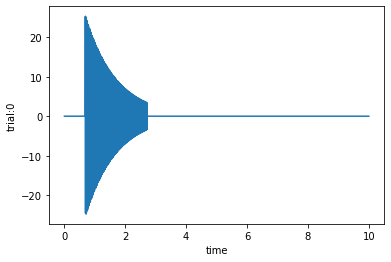

Trial 1:   [amp, frequency, gamma, t0] = [50.0, 90.0, 0.0, 5.764067502485879]


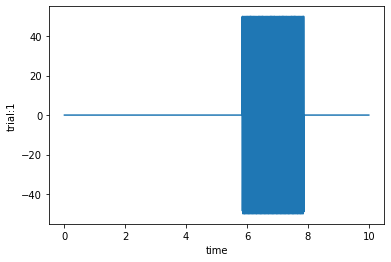

Trial 2:   [amp, frequency, gamma, t0] = [25.5, 100.0, 0.0, 6.412930247526111]


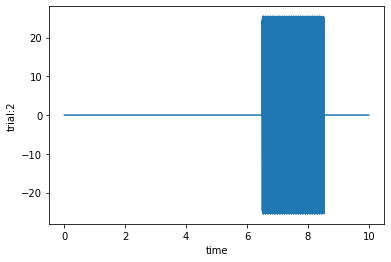

Trial 3:   [amp, frequency, gamma, t0] = [1.0, 90.0, 0.0, 1.327630807917484]


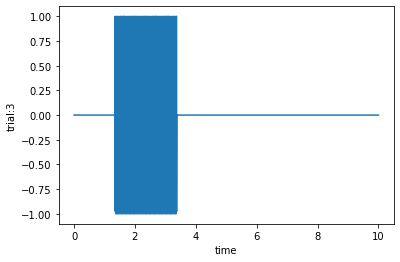

Trial 4:   [amp, frequency, gamma, t0] = [50.0, 90.0, 0.0, 1.0109699205256375]


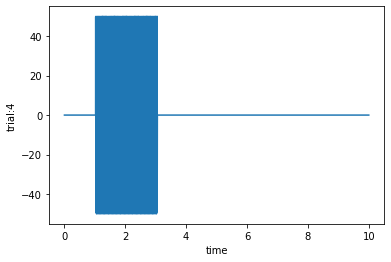

In [1736]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis=[10/OS.N*j for j in range(OS.N)] 
for i in range(OS.trials):
    print("Trial "+str(i)+":   [amp, frequency, gamma, t0] = "+str(OS.output[i][0]))
    plt.plot(xaxis, OS.output[i][1])
    plt.xlabel("time")
    plt.ylabel("trial:" +str(i))
    plt.show()

In [1737]:
#builds rho statistic
y=OS.rho()

In [1738]:
#performs modulation/ bg-fg value finding on rho
z=OS.window(.3)

initalizing output...
t0: 0.6766312618617767  T0_2D: 1
t0: 5.764067502485879  T0_2D: 9
t0: 6.412930247526111  T0_2D: 10
t0: 1.327630807917484  T0_2D: 2
t0: 1.0109699205256375  T0_2D: 1


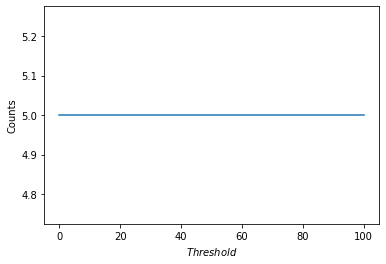

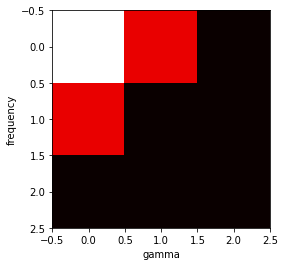

In [1739]:
OS.test_plotter( 100, 300, var1=0, var2=0)


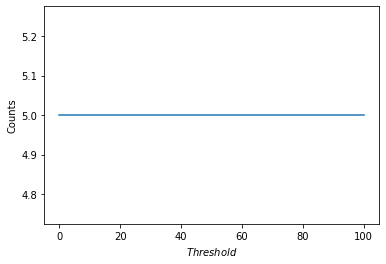

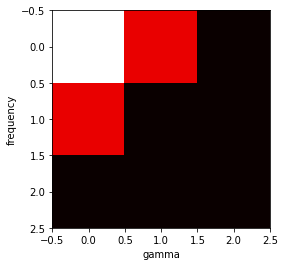

In [1740]:
OS.test_plotter( 100, 300, var1=0, var2=0,bg_test=False)

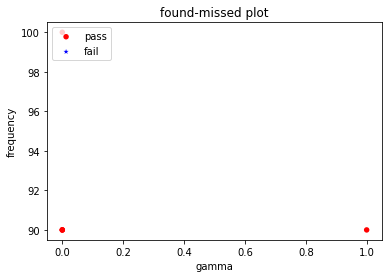

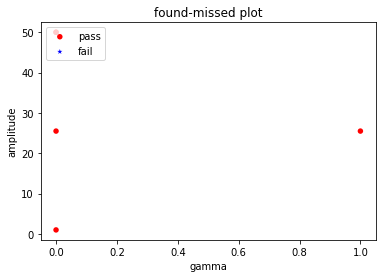

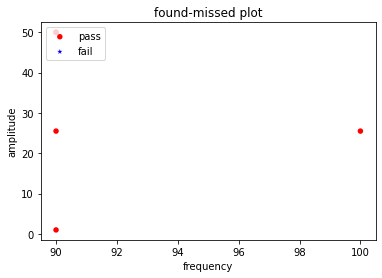

In [1741]:
#scatter plot of fails & passes given threshold t

# Amplitude vs. gamma
OS.Scatter_plotter( 4, 2, 1)

# Amplitude vs. frequency
OS.Scatter_plotter( 4, 2, 0)

# frequency vs. gamaa
OS.Scatter_plotter( 3, 1, 0)

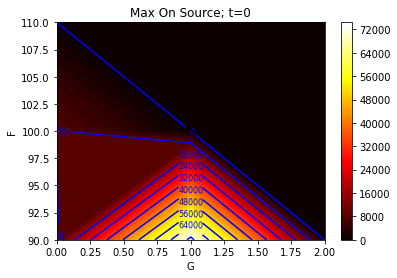

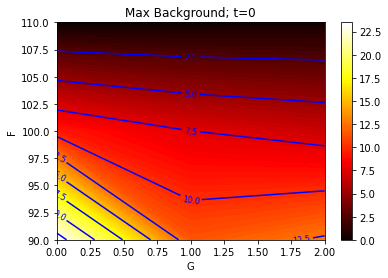

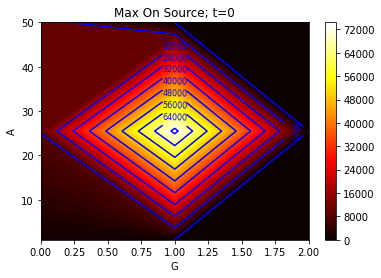

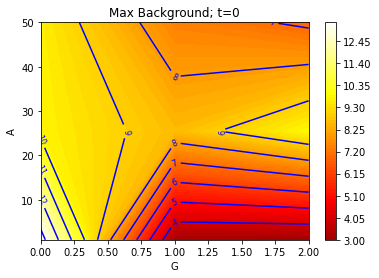

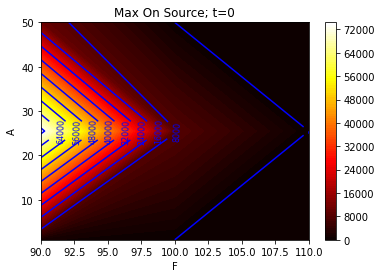

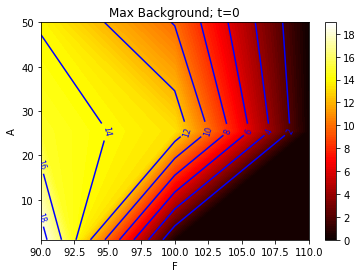

In [1742]:
#heat plot of 
#     1. average max onsource rho, over trials
#     2. max background rho, over templates

# Amplitude vs. gamma
OS.heatmap(2,1,0)


# Amplitude vs. frequency
OS.heatmap(2,0,0)

# frequency vs. gamaa
OS.heatmap(1,0,0)

# Errors
Need-fixing:
<br>
<br>Completed:
- ~~Error 1: The json does not save~~
    - the old error was fixed; The issue was due to trying to store np arrays inside the the json file without casting them to lists first. Now it seems the only issue is a jupyter thing its self; it won't output dictionaries after a certain size. However, it works fine from a personal laptop terminal. For the moment, it is commeneted out though, just to avoid saving unnecessary files during debugging

- ~~Error 2: lists are coming out the wrong size~~ 
    - This was because of a bunch approximations I haphazardly made in 'waveform' ; after cleaning up the function, everything is now coming out the correct size

- ~~Error 3: windowing produces errors given odd half-window sizes~~
    - This was due to 'throwing away' the end components of the modulated statistic within the modulation function; the result was shorter than expected outputs, resulting in array off-by-one errors in 'window'

- ~~Error 4: Graphs look funny~~
    - turns out this wasn't an error at all; the graphs just looked funny because the resolution was low

# To-do's: 
- todo 1: update commenting
    - the commenting in shoddy and confusing in  a lot of places -- go back and explain what you're donig
- todo 2: clean up attribute use
    - theres a lot of variables/ attributes that are often randomly rederived or named poorly; this could use some cleaning too
- todo 3: extra plots
    - now that everything seems to be running, make some prettier plots

# Parameter Estimator:
- constructor:  saves the input variables internally. Argument 'inital' is for setting the inital starting values to something specific, as opposed to randomly generating the start values; mostly for testing purposes.
- estimation: implements the metropolitans hasting algorithm to build a distribution/ mode value for [a,f,g,t] , based on the inputted Statudio data. Currently uses loglikelihood ratio. NOTE: currently the log likelihood ratio is used; additionally, the 'test value' is currently not randomly generated. This was done for testing purposes, and seemed to give a better distribution when fixed at 0.6; but it could be quickly changed back. Taking the log of the uniformly distributed test statistic may be appropriate as well, if we switched to likelihood difference instead of ratio.
- log_likelihood : builds a log likelihood function off the provided data + parameter inputs. NOTE: the '$ln(2\cdot \pi \cdot \sigma^2)$' term was not included in the sum, as I was switching between using the difference between log likelihoods and the ratio of log likelihoods as the acceptance/rejection test statistic. It may be beneficial to add this back in.
- jump initializer: initalizes the first point in the parameter space to test, provided that argument 'initial' is an empty list []
- jump : generates a new parameter set to test. The newley generated parameters should be close to the old ones, as the mean of the normal distributions generating them are set of to the current parameter locations. **NOTE TO SELF: ELABORATE** on how you defined the respective standard deviations eventually 
- clear : resets attributes, allowing for a fresh test
- para_meters : picks out the mode of the generated 4-dimensional [a,f,g,t] distribution.
- corner_plot : makes a corner plot of the histogram ; see graphs below

Things seem to be in order with this function, but we will probably need to test it more. One issue is that it seems to predict amplitude poorly moreoften than other variables -- one reason for this is that minor changes to other variables often outweigh changes to amplitude. So, if f,g and t have already 'settled' into values, any jump which would allow A to improve would be counteracted by changes in f, g and t; these counteracting changes cause the log likelihood ratio to be so small -- often 0.1 to 0.01 in order- that the hardly pass random tests/ reasonable fixed tests. So, A gets stuck. 

It's also important to sync up data from statudio objects and paramestem objects; paramestem assumes its being fed data with the same boundaries as the statudio data/ trail. 

In [1933]:
class ParamEstem:
    
    def __init__(self,d_i, initial=[], T=10, t0_tf=2, b=3, A0=1, Af=50, F0=90, Ff=110, g0=0, gf=2, t0=0):

        #initalize attributes for performing random jumps
        self.A0, self.Af = A0, Af
        self.F0, self.Ff = F0, Ff
        self.g0, self.gf = g0, gf
        self.t0, self.tf = t0, T-t0_tf
        
        #initalizes 'unit step sizes' for jumping
        R=((A0-Af)**2+(F0-Ff)**2+(g0-gf)**2+(t0-self.tf)**2)**(1/2)
        self.LA=(Af-A0)/R
        self.LF=(Ff-F0)/R
        self.Lg=(gf-g0)/R
        self.Lt=(T-t0_tf-t0)/R

        #initalizes time-related attributes
        self.d_i=d_i
        self.dt=T/len(d_i)
        self.T=T
        self.t0_tf=t0_tf
        
        #initalizes simga for which uniform_sigma=normal_sigma (see UN graph below)
        self.sigma=b/(math.sqrt(3))
        
        #initalize variables for holding data, current location, and final parameters 
        self.values=[]
        self.loc_cur=initial 
        self.parameters=[]
    
    def estimation(self,n):
        
        #finds inital location in parameter space
        
        if (len(self.loc_cur)==0):
            self.jump_initializer()
        
        count=0
        us=[]
        #performs n-1 jumps/ samplings
        for i in range(n-1):
            loc_pos=self.jump()
            
            #compute likelihood ratiot
            print(self.log_likelihood(self.loc_cur, self.d_i, self.dt, self.t0_tf, self.sigma))
            L1=np.exp(self.log_likelihood(self.loc_cur, self.d_i, self.dt, self.t0_tf, self.sigma))
            L2=np.exp(self.log_likelihood(loc_pos, self.d_i, self.dt, self.t0_tf, self.sigma))
            LR=L2/L1
            
            #see if current location increases likelihood/ passes test
            test=np.random.rand()
            count+=1
            us.append(test)
            if (LR>test):
                
                us=[]
                count=0
                
                self.loc_cur=loc_pos
                
            #append final parameter values
            self.values.append(self.loc_cur)
            
            print("count: ",count)
            print("loc_cur: ",self.loc_cur)
            print("L1: ",L1)
            print("loc_pos: ",loc_pos)
            print("L2: ",L2)
            print("  ")
            print("LR: ",LR)
            print("  ")
            print(us)
            print("  ")
            print("  ")
          
    def log_likelihood(self, theta, d_i, dt, t0_tf, sigma):
        
        #initalize some variables
        N=len(d_i)
        a, f, g, t= theta
        w = 2 * np.pi * f
        START_INDEX=math.floor(t/dt)
        
        
        #initalize the array to have proper timestaps/zeros
        SIG_LEN =( math.floor(t0_tf/dt)+1 if (t0_tf != self.T) else N )      # Calculate # of indexes signal takes
        MODEL = np.zeros(N)                       #initalize injected signal
        for i in range(SIG_LEN):
             MODEL[ START_INDEX + i]=t+i*dt       #fill in injected signal
        
        #input the waveform
        SR =  MODEL[ START_INDEX : START_INDEX+SIG_LEN][:]
        MODEL[ START_INDEX : START_INDEX+SIG_LEN] = a*np.sin(w*(SR-t))*np.exp(-g*( SR-t))
        
        return -0.5 * np.sum(((d_i - MODEL) ** 2) / (sigma**2))
        
        
    def jump_initializer(self):
        
        #uniformly self inital values
        a=self.A0+(self.Af-self.A0)*np.random.rand()
        f=self.F0+(self.Ff-self.F0)*np.random.rand()
        g=self.g0+(self.gf-self.g0)*np.random.rand()
        t=self.t0+(self.tf-self.t0)*np.random.rand()
        
        #intialize step-related attributes
        step=[a,f,g,t]
        self.values.append(step)
        self.loc_cur=step
    
    def jump(self):
        #initalize conditions so loop starts
        a=self.Af+1
        f=self.Ff+1
        g=self.gf+1
        t=self.tf+1
        
        #bring current location into a local variable
        p=self.loc_cur
        
        #normall select new variable values for a,f,g,t
        while ((self.Af<a) or (a<self.A0)):
            a=np.random.normal(loc=p[0], scale=20*self.LA)
            #a=self.A0+(self.Af-self.A0)*np.random.rand()
        
        while ((self.Ff<f) or (f<self.F0)):
            f=np.random.normal(loc=p[1], scale=20*self.LF)
            #f=self.F0+(self.Ff-self.F0)*np.random.rand()
        
        while ((self.gf<g) or (g<self.g0)):
            g=np.random.normal(loc=p[2], scale=20*self.Lg)
            #g=self.g0+(self.gf-self.g0)*np.random.rand()
        
        while ((self.tf<t) or (t<self.t0)):
            t=np.random.normal(loc=p[3], scale=20*self.Lt)
            #t=self.t0+(self.tf-self.t0)*np.random.rand()
        
        return [a,f,g,t]
    
    
    #rest attributes for starting fresh random trials
    def clear(self):
        self.values=[]
        self.loc_cur=[]
        self.parameters=[]
    
    #obtain the/a peak of the multi-dimensional distribution 
    def para_meters(self):
        self.parameters=[]
        #define the multi-dim histogram
        histo=np.histogramdd(np.array(self.values))
        x=histo[0]
       
        #initalize loop variables 
        shape=x.shape
        max_val=0
        
        #initalize holder for co-ordinates of peak
        key=(0,0,0,0)

        for i in range(shape[0]):
            for j in range(shape[1]):
                for k in range(shape[2]):
                    for w in range(shape[3]):
                        
                        #loop through the ddarray to find the global max
                        if (max_val<=x[i,j,k,w]):
                            max_val=x[i,j,k,w]
                            key=(i,j,k,w)
        
        #return the values in the ddarray at the location of (key)
        for q in range(4):
            self.parameters.append(histo[1][q][key[q]])
        
        return self.parameters
        
    def corner_plot(self):
       
        data=np.array(self.values)  
        ndim=4
        
        # This is the empirical mean of the sample:
        value2 = np.mean(data, axis=0)
        
        figure = corner.corner(data, labels=[r"$A$", r"$F$", r"$G$", r"$t0$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},color='b')

        # Extract the axes
        axes = np.array(figure.axes).reshape((ndim, ndim))

        # Loop over the diagonal
        for i in range(ndim):
            ax = axes[i, i]
            ax.axvline(value2[i], color="r")
    
        # Loop over the histograms
        for yi in range(ndim):
            for xi in range(yi):
                ax = axes[yi, xi]
                ax.axvline(value2[xi], color="r")
                ax.axhline(value2[yi], color="r")
                ax.plot(value2[xi], value2[yi], "sr")
        

Old singular test:

true values:  [50.0, 100.0, 2.0, 1.6175273583390162]
-45627.38870993693
count:  1
loc_cur:  [3.3719987289340927, 105.25912660043393, 0.4901604031693101, 5.507410415854237]
L1:  0.0
loc_pos:  [21.42384659520705, 104.35898992307546, 0.19288942061707348, 1.8074723417162333]
L2:  0.0
  
LR:  nan
  
[0.3109168504698967]
  
  
-45627.38870993693
count:  2
loc_cur:  [3.3719987289340927, 105.25912660043393, 0.4901604031693101, 5.507410415854237]
L1:  0.0
loc_pos:  [12.08477567796713, 107.20440862932736, 1.0589077373973872, 5.461580862109281]
L2:  0.0
  
LR:  nan
  
[0.3109168504698967, 0.3232122046414415]
  
  
-45627.38870993693
count:  3
loc_cur:  [3.3719987289340927, 105.25912660043393, 0.4901604031693101, 5.507410415854237]
L1:  0.0
loc_pos:  [22.880740524504656, 104.85042115276951, 1.583782153186983, 2.705299310822242]
L2:  0.0
  
LR:  nan
  
[0.3109168504698967, 0.3232122046414415, 0.00036434448160949096]
  
  
-45627.38870993693
count:  4
loc_cur:  [3.3719987289340927, 105.2591266004339

<ipython-input-1933-36215e6a15a0>:49: RuntimeWarning: invalid value encountered in double_scalars
  LR=L2/L1



LR:  nan
  
[0.3109168504698967, 0.3232122046414415, 0.00036434448160949096, 0.9977050170938357, 0.07023243815258351, 0.24731551467246782, 0.2958640421887352, 0.6635591639467754, 0.7416780805666406, 0.03197218967011339, 0.7554692156575269, 0.5362731328590629, 0.37584970353243896, 0.3714000406150938, 0.9770958134449023, 0.12594250206089108, 0.16446746850882277, 0.27002769426264106, 0.11961553503011346, 0.8929898947029327, 0.37283220733235967, 0.8532450360743142, 0.05175438059743076, 0.6582674242867561, 0.8377356226629044, 0.6723628907638349, 0.5841278481507249, 0.4227919580282361, 0.689945903620703, 0.18570721135251322, 0.7680152656497552, 0.12610772606046616, 0.11239257452343776, 0.13432207859936585, 0.035515467498665076, 0.8919353570005403, 0.3036093299490433, 0.1856615885827384, 0.3102672244429804, 0.5168551660167608, 0.7964914424189034, 0.7788855022620819, 0.8126607463361135, 0.3108129782675978, 0.058646239690077984, 0.4474690901991645, 0.6153563919572845, 0.35920799511204404, 0.95

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3 have no dynamic range. Please provide a `range` argument.

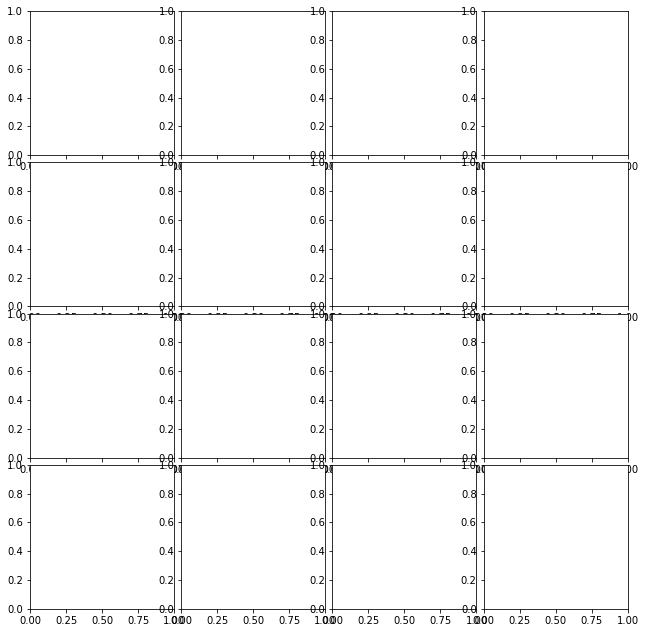

In [1934]:
PE.clear()
di=OS.output[0][1]
init=OS.output[0][0]
PE=ParamEstem(di,b=1, T=np.pi**2)

print("true values: ",OS.output[0][0])
PE.estimation(100)

print("peak values: ", PE.para_meters())

PE.corner_plot()


# Multi-tester: 
takes the Statudio object generated in the upper half of the notebook, loops through a subset of its datasets, and attempts to find a fit using a ParamEstem object. Then, plots for the true and modal values are given as outputs, as well as a corner-plot version of the 4-d distribution of [a,f,g,t]

true values:  [25.5, 90.0, 1.0, 0.6766312618617767]
peak values:  [30.39479074656238, 90.00007504117988, 1.5999881402560476, 0.00027161685260401747]
 
Trial 0:   [amp, frequency, gamma, t0] = [25.5, 90.0, 1.0, 0.6766312618617767]


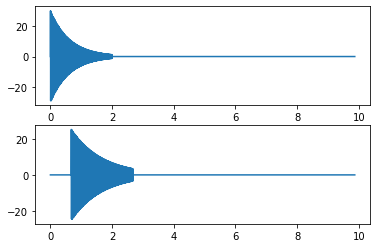

KeyboardInterrupt: 

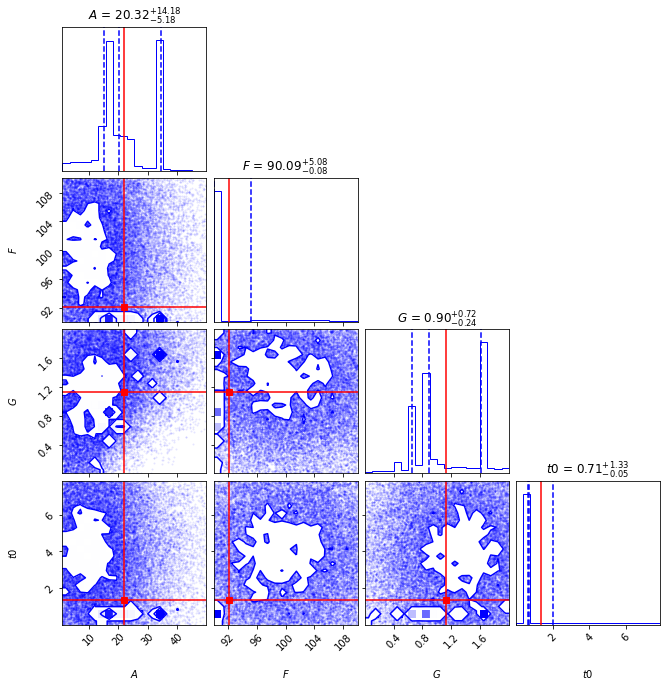

In [1875]:
from matplotlib import pyplot as plt
%matplotlib inline


for i in range(5):
    PE.clear()
    di=OS.output[i][1]
    
    init=np.array(OS.output[i][0])-np.array([10,0,0,0])
    
    PE=ParamEstem(di,b=0.001, T=np.pi**2)
    #initial=OS.output[i][0]
    PE.estimation(200000)
    print("true values: ",OS.output[i][0])
    print("peak values: ", PE.para_meters())
    print(" ")

    MODEL=esti_plot(PE.para_meters(), OS.N, OS.T, OS.t0_tf)

    xaxis=[OS.T/len(di)*j for j in range(len(di))] 
    
    print("Trial "+str(i)+":   [amp, frequency, gamma, t0] = "+str(OS.output[i][0]))
    
    fig, (ax0, ax1) = plt.subplots(2, 1)
    ax0.plot(xaxis, MODEL)
    ax1.plot(xaxis,OS.output[i][1])
    plt.show()
    PE.corner_plot()
    PE.clear()

# Normal Histogram Modeling
For noise modeled by a uniform distribution over [-b, b] we have  $\sigma=\frac{b}{\sqrt{3}}$. To ease the transition from a unifrom model of the noise to a gaussian model, we set the deviation of the normal distribution to be $\sigma=\frac{b}{\sqrt{3}}$.

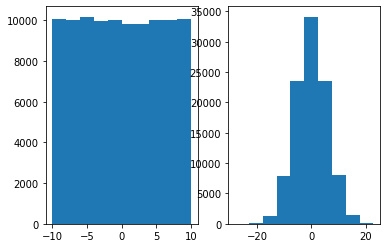

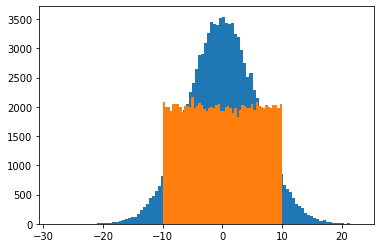

In [1891]:
b=10
fig, (ax0, ax1) = plt.subplots(1, 2)

uni_hist=-b+2*b*np.random.rand(100000)
ax0.hist(uni_hist)

nor_hist=np.random.normal(scale=(b/math.sqrt(3)), size=100000)
ax1.hist(nor_hist)

plt.show()

plt.hist(nor_hist, bins=100);
plt.hist(uni_hist, bins=50);

# Under The Hood:
Ultimatly, esti_plot is just a copy of 'waveform generator' used to build waveforms for testing. But, a version of it is used within Paramestim as well, so an outside copy is useful for testing/ checking waveforms are generated correctly. Below it is a region to test loglikelihood values for test data vs. correpsonding generated 

In [ ]:
    def esti_plot(theta, N, T, t0_tf):
        
        #initalize some variables
        a, f, g, t= theta

        dt=T/N
        w = 2 * np.pi * f
        START_INDEX=math.floor(t/dt)
    
        #initalize the array to have proper timestaps/zeros
        SIG_LEN =( math.floor(t0_tf/dt)+1 if (t0_tf != T) else N )      # Calculate # of indexes signal takes
        MODEL = np.zeros(N)                       #initalize injected signal
        for i in range(SIG_LEN):
             MODEL[ START_INDEX + i]=t+i*dt       #fill in injected signal
        
        #input the waveform
        SR =  MODEL[ START_INDEX : START_INDEX+SIG_LEN][:]
        MODEL[ START_INDEX : START_INDEX+SIG_LEN] = a*np.sin(w*(SR-t))*np.exp(-g*( SR-t))

        return MODEL

In [ ]:
MODEL=esti_plot(OS.output[0][0], OS.output[0][1], OS.dt, OS.T, OS.t0_tf,0)

-1*(1/2)*np.sum(((di - MODEL) ** 2) / (sigma**2))
-0.5 * np.sum(((di - MODEL) ** 2) / (sigma**2))

# TO DO: 
a lot 

# TEST-AREA

In [ ]:
%%timeit
x=OnSource(10, 10, 10, 4, 10, 4, 0.3, 1, N_t=250)
#N_A, N_g, N_f, t0_tf, T, b, D, trials, N_t

In [1921]:
am=0
fm=0
gm=0
tm=0

n=len(PE.values)
for v in PE.values:
    am+=v[0]
    fm+=v[1]
    gm+=v[2]
    tm+=v[3]

means=np.array([am,fm,gm,tm])/n
print(means)

[ 9.5863024  99.50479441  1.1624467   3.78331886]


In [1907]:
histo=np.histogramdd(np.array(PE.values))

In [1930]:
OS.output[0][0]

[50.0, 100.0, 2.0, 1.6175273583390162]